# 初始化环境 

In [1]:
import os
# 对于高版本python（3.11）需要高版本spark与之配套
#os.environ["SPARK_HOME"] = R"F:\spark_local\spark-3.4.2-bin-hadoop3"
#os.environ["HADOOP_HOME"] = R"F:\spark_local\hadoop-3.3.5"

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
import pandas as pd

In [4]:
spark = (
         SparkSession
         .builder
         .master("local[4]") 
         .appName("SimpleApp")
         .getOrCreate()
        )

# sparkSQL 中的DataFrame

## 创建DataFrame

### 生成序列

使用内置函数创建 spark.range(start,end,step)  数据区间[start,end) ,start默认是0  step 默认是1

In [5]:
spark.range(10)

DataFrame[id: bigint]

In [6]:
spark.range(10).show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



### 由其他数据对象转换成DataFrame

spark.createDataFrame(data,schema)
- data 数据：列表、RDD、pandas的dataframe都可以
- schema ：元数据

In [7]:
scores = [["张三","男",89],["李四","男",99],["王五","女",8]]

In [8]:
string_schema = """
`姓名` string
,`性别` string
,score int
"""
# 中文的字段名，或者别名需用``上引号（tab键上面的）括起来
spark.createDataFrame(scores,schema=string_schema).show()

+----+----+-----+
|姓名|性别|score|
+----+----+-----+
|张三|  男|   89|
|李四|  男|   99|
|王五|  女|    8|
+----+----+-----+



In [9]:
sc = spark.sparkContext
rdd1=sc.parallelize([["张三","男",89],["李四","男",99],["王五","女",8]])

In [10]:
spark.createDataFrame(rdd1,schema=string_schema).show()

+----+----+-----+
|姓名|性别|score|
+----+----+-----+
|张三|  男|   89|
|李四|  男|   99|
|王五|  女|    8|
+----+----+-----+



In [11]:
df = pd.DataFrame(scores,columns=["姓名","性别","score"])
df

,姓名,性别,score
0,张三,男,89
1,李四,男,99
2,王五,女,8


In [12]:
spark.createDataFrame(df).show()

+----+----+-----+
|姓名|性别|score|
+----+----+-----+
|张三|  男|   89|
|李四|  男|   99|
|王五|  女|    8|
+----+----+-----+



### 通过数据文件创建DataFrame

In [13]:
# 文本文件CSV
moviesDF = spark.read.csv("./data/movies.csv",header=True)
moviesDF.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [14]:
# parquet 列式存储文件，每个列的数据单独存储成一个文件
movies_parquet = spark.read.parquet("./data/movies.parquet")
movies_parquet.show(5)

+-----------------+------------------+-------------+
|       actor_name|       movie_title|produced_year|
+-----------------+------------------+-------------+
|McClure, Marc (I)|      Coach Carter|         2005|
|McClure, Marc (I)|       Superman II|         1980|
|McClure, Marc (I)|         Apollo 13|         1995|
|McClure, Marc (I)|          Superman|         1978|
|McClure, Marc (I)|Back to the Future|         1985|
+-----------------+------------------+-------------+
only showing top 5 rows



### 数据库

需要在spark的jars文件夹放入驱动程序

In [15]:
url="jdbc:mysql://localhost:3306/cda?user=root&password=112233"

In [16]:
customer_detail = (spark.read
                     .format("jdbc")
                     .option("url",url)
                     .option("query","select * from customer_detail limit 10")
                     .load()
                    )
customer_detail.show()

+--------------------+----------+--------+--------+----------+----------+---------+----+----+--------+
|              合同ID|  客户编号|客户名称|合同期限|  放款日期|  到期时间| 合同金额|性别|年龄|婚姻状况|
+--------------------+----------+--------+--------+----------+----------+---------+----+----+--------+
|0005f28cc32945ecb...|1808067960|    王倩|      18|2018-08-08|2020-02-16| 80000.00|  女|  33|    已婚|
|000d5719bfee496c8...|1711231404|  景金凤|       6|2017-11-23|2018-05-23| 36000.00|  女|  42|    已婚|
|002837ccb279426fa...|1809259131|  王理传|      12|2018-09-26|2019-09-28| 68000.00|  男|  43|    已婚|
|006a6fea8cde4e9bb...|1802064089|  林绍监|      12|2018-02-06|2019-02-06|272000.00|  男|  43|    已婚|
|007075347e204f339...|1806195568|  彭晓军|       6|2018-06-20|2018-12-20| 86000.00|  男|  44|    已婚|
|008639881df24730b...|1803224620|  梁应龙|       6|2018-03-23|2018-09-23|113000.00|  男|  53|    已婚|
|0124bdb32b614ec3a...|1712072461|    王霞|       6|2018-06-13|2018-12-13|204000.00|  女|  36|    已婚|
|0140ab0461bf4353a...|1806255706|  李勇军|     

In [19]:
# 也可以写数据库
(customer_detail.write
.mode("append")
.format("jdbc")
.option("url",url)
.option("dbtable","contact")
.save())

In [20]:
 (spark.read
         .format("jdbc")
         .option("url",url)
         .option("query","select count(*) from contact")
         .load()
   ).show()

+--------+
|count(*)|
+--------+
|      30|
+--------+



## DataFrame API

与RDD类似，DataFrame的API也分为两类：transformation和action

### Transformation

#### 选择列select  selectExpr
select与sql中的类似，选取指定列（指定条件的数据）



selectExpr与select 类似，不同的是可以解析表达式（底层进行了SQL转化）

In [21]:
movies_parquet.printSchema()

root
 |-- actor_name: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- produced_year: long (nullable = true)



In [22]:
movies_parquet.select("*","movie_title").show()

+-----------------+--------------------+-------------+--------------------+
|       actor_name|         movie_title|produced_year|         movie_title|
+-----------------+--------------------+-------------+--------------------+
|McClure, Marc (I)|        Coach Carter|         2005|        Coach Carter|
|McClure, Marc (I)|         Superman II|         1980|         Superman II|
|McClure, Marc (I)|           Apollo 13|         1995|           Apollo 13|
|McClure, Marc (I)|            Superman|         1978|            Superman|
|McClure, Marc (I)|  Back to the Future|         1985|  Back to the Future|
|McClure, Marc (I)|Back to the Futur...|         1990|Back to the Futur...|
|Cooper, Chris (I)|  Me, Myself & Irene|         2000|  Me, Myself & Irene|
|Cooper, Chris (I)|         October Sky|         1999|         October Sky|
|Cooper, Chris (I)|              Capote|         2005|              Capote|
|Cooper, Chris (I)|The Bourne Supremacy|         2004|The Bourne Supremacy|
|Cooper, Chr

In [23]:
# 查询电影的上映年代
#select 不能放字符串表达式
# 这里会报错，需要用selectExpr
movies_parquet.select("movie_title","produced_year - produced_year%10").show(5) 

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `produced_year - produced_year%10` cannot be resolved. Did you mean one of the following? [`produced_year`, `actor_name`, `movie_title`].;
'Project [movie_title#107, 'produced_year - produced_year%10]
+- Relation [actor_name#106,movie_title#107,produced_year#108L] parquet


In [24]:
movies_parquet.selectExpr("movie_title","produced_year - produced_year%10").show(5) 

+------------------+--------------------------------------+
|       movie_title|(produced_year - (produced_year % 10))|
+------------------+--------------------------------------+
|      Coach Carter|                                  2000|
|       Superman II|                                  1980|
|         Apollo 13|                                  1990|
|          Superman|                                  1970|
|Back to the Future|                                  1980|
+------------------+--------------------------------------+
only showing top 5 rows



In [25]:
# 使用*查询所有字段
movies_parquet.selectExpr("*").show(5) 

+-----------------+------------------+-------------+
|       actor_name|       movie_title|produced_year|
+-----------------+------------------+-------------+
|McClure, Marc (I)|      Coach Carter|         2005|
|McClure, Marc (I)|       Superman II|         1980|
|McClure, Marc (I)|         Apollo 13|         1995|
|McClure, Marc (I)|          Superman|         1978|
|McClure, Marc (I)|Back to the Future|         1985|
+-----------------+------------------+-------------+
only showing top 5 rows



#### 过滤行 filter, where

filter where 用来设置条件筛选字段，两者用法一致

In [26]:
# 选择2000年以前电影
movies_parquet.where("produced_year<2000").show()

+-------------------+--------------------+-------------+
|         actor_name|         movie_title|produced_year|
+-------------------+--------------------+-------------+
|  McClure, Marc (I)|         Superman II|         1980|
|  McClure, Marc (I)|           Apollo 13|         1995|
|  McClure, Marc (I)|            Superman|         1978|
|  McClure, Marc (I)|  Back to the Future|         1985|
|  McClure, Marc (I)|Back to the Futur...|         1990|
|  Cooper, Chris (I)|         October Sky|         1999|
|  Cooper, Chris (I)|      A Time to Kill|         1996|
|  Cooper, Chris (I)|     American Beauty|         1999|
|  Cooper, Chris (I)| The Horse Whisperer|         1998|
|Knight, Shirley (I)|  As Good as It Gets|         1997|
|    Jolie, Angelina|  The Bone Collector|         1999|
|     Danner, Blythe|    Forces of Nature|         1999|
|     Danner, Blythe|         The X Files|         1998|
|  Bissonnette, Joel|          Fight Club|         1999|
|      Butters, Mike|        Da

不等比较使用的操作符是 !=

In [27]:
# 非 2000年的
movies_parquet.where("produced_year!=2000").show()

+-----------------+--------------------+-------------+
|       actor_name|         movie_title|produced_year|
+-----------------+--------------------+-------------+
|McClure, Marc (I)|        Coach Carter|         2005|
|McClure, Marc (I)|         Superman II|         1980|
|McClure, Marc (I)|           Apollo 13|         1995|
|McClure, Marc (I)|            Superman|         1978|
|McClure, Marc (I)|  Back to the Future|         1985|
|McClure, Marc (I)|Back to the Futur...|         1990|
|Cooper, Chris (I)|         October Sky|         1999|
|Cooper, Chris (I)|              Capote|         2005|
|Cooper, Chris (I)|The Bourne Supremacy|         2004|
|Cooper, Chris (I)|            The Town|         2010|
|Cooper, Chris (I)|          Seabiscuit|         2003|
|Cooper, Chris (I)|      A Time to Kill|         1996|
|Cooper, Chris (I)|Where the Wild Th...|         2009|
|Cooper, Chris (I)|         The Muppets|         2011|
|Cooper, Chris (I)|     American Beauty|         1999|
|Cooper, C

组合一个或多个比较表达式, 我们将使用OR和AND表达式运算符

In [28]:
# 2000年到2005年之间的电影
movies_parquet.where("produced_year>2000 and produced_year<2005").show()

+-------------------+--------------------+-------------+
|         actor_name|         movie_title|produced_year|
+-------------------+--------------------+-------------+
|  Cooper, Chris (I)|The Bourne Supremacy|         2004|
|  Cooper, Chris (I)|          Seabiscuit|         2003|
|  Cooper, Chris (I)| The Bourne Identity|         2002|
|  Cassavetes, Frank|              John Q|         2002|
|Knight, Shirley (I)|Divine Secrets of...|         2002|
|    Jolie, Angelina|Lara Croft: Tomb ...|         2001|
|    Jolie, Angelina|           Alexander|         2004|
|    Jolie, Angelina|          Shark Tale|         2004|
|    Jolie, Angelina|Lara Croft Tomb R...|         2003|
|    Jolie, Angelina|Sky Captain and t...|         2004|
|     Yip, Françoise|      Blade: Trinity|         2004|
|     Cueto, Esteban|   Collateral Damage|         2002|
|     Cueto, Esteban|   The Scorpion King|         2002|
|     Cueto, Esteban|                 xXx|         2002|
|     Danner, Blythe|    Meet t

#### distinct, dropDuplicates
去除重复行

In [29]:
# 电影数量
movies_parquet.selectExpr('count(movie_title)').show()
# 去重后的数量
movies_parquet.select('movie_title').distinct().selectExpr('count(movie_title)').show()

+------------------+
|count(movie_title)|
+------------------+
|             31393|
+------------------+

+------------------+
|count(movie_title)|
+------------------+
|              1409|
+------------------+



In [30]:
movies_parquet.dropDuplicates(["movie_title"]).selectExpr('count(movie_title)').show()

+------------------+
|count(movie_title)|
+------------------+
|              1409|
+------------------+



#### sort(columns), orderBy(columns)

In [31]:
# 根据电影title名称长短排序
 # 默认升序排序
(movies_parquet
 .dropDuplicates(["movie_title"])
 .selectExpr("*","length(movie_title) t_len")
 .sort("t_len") 
).show()

+--------------------+-----------+-------------+-----+
|          actor_name|movie_title|produced_year|t_len|
+--------------------+-----------+-------------+-----+
|    Efremov, Mikhail|         12|         2007|    2|
|      Franko, Victor|         21|         2008|    2|
|   Baessato, Giacomo|         RV|         2006|    2|
|     Newman, Laraine|         Up|         2009|    2|
|      Hayley, Robert|         X2|         2003|    2|
|       Schaap, David|        300|         2006|    3|
|        Cray, Ed (I)|        Ali|         2001|    3|
|   LaMarche, Maurice|        Elf|         2003|    3|
|Fay, Zachary Chri...|        Hop|         2011|    3|
|  Herthum, Harold G.|        JFK|         1991|    3|
|     Slattery, Cindy|        Rio|         2011|    3|
|       Butters, Mike|        Saw|         2004|    3|
|      Cueto, Esteban|        xXx|         2002|    3|
|  Jackson, Samuel L.|       1408|         2007|    4|
|        Allen, Woody|       Antz|         1998|    4|
| Cromwell

In [32]:
# 使用sparkSQL函数实现升降的设定
from pyspark.sql.functions import desc,asc
(movies_parquet
 .dropDuplicates(["movie_title"])
 .selectExpr("*","length(movie_title) t_len")
 .sort(desc("t_len"),asc("produced_year")) 
).show()


+--------------------+--------------------+-------------+-----+
|          actor_name|         movie_title|produced_year|t_len|
+--------------------+--------------------+-------------+-----+
|             Luenell|Borat: Cultural L...|         2006|   83|
|Moseley, William (I)|The Chronicles of...|         2005|   62|
|        Cyrus, Miley|Hannah Montana & ...|         2008|   57|
|      Galtsev, Yuriy|Istoriya pro Rich...|         1997|   56|
|Moseley, William (I)|The Chronicles of...|         2010|   56|
|     Aduramo, Israel|Pirates of the Ca...|         2003|   54|
|     Newton, Thandie|Interview with th...|         1994|   50|
|        Roehm, Jason|Indiana Jones and...|         2008|   50|
|      Hayley, Robert|Percy Jackson & t...|         2010|   50|
|        Grieve, Phil|The Lord of the R...|         2001|   49|
|Bonham Carter, He...|Wallace & Gromit ...|         2005|   48|
|    Pugh, Robert (I)|Master and Comman...|         2003|   47|
| Browning, Emily (I)|Lemony Snicket's .

#### limit(n)

In [33]:
# 选择前3行
movies_parquet.limit(3).show()

+-----------------+------------+-------------+
|       actor_name| movie_title|produced_year|
+-----------------+------------+-------------+
|McClure, Marc (I)|Coach Carter|         2005|
|McClure, Marc (I)| Superman II|         1980|
|McClure, Marc (I)|   Apollo 13|         1995|
+-----------------+------------+-------------+



In [34]:
# 显示前3行
movies_parquet.show(3)

+-----------------+------------+-------------+
|       actor_name| movie_title|produced_year|
+-----------------+------------+-------------+
|McClure, Marc (I)|Coach Carter|         2005|
|McClure, Marc (I)| Superman II|         1980|
|McClure, Marc (I)|   Apollo 13|         1995|
+-----------------+------------+-------------+
only showing top 3 rows



#### union(otherDataFrame)
相当于SQL的`UNION ALL`,去重用前面的方法

In [35]:
df1 = spark.createDataFrame([[1, 2, 3]], ["col0", "col1", "col2"])
df1.show()
df2 = spark.createDataFrame([[4, 5, 6]], ["col1", "col2", "col0"])
df2.show()

+----+----+----+
|col0|col1|col2|
+----+----+----+
|   1|   2|   3|
+----+----+----+

+----+----+----+
|col1|col2|col0|
+----+----+----+
|   4|   5|   6|
+----+----+----+



In [36]:
df1.union(df1).show()
df1.union(df2).show()

+----+----+----+
|col0|col1|col2|
+----+----+----+
|   1|   2|   3|
|   1|   2|   3|
+----+----+----+

+----+----+----+
|col0|col1|col2|
+----+----+----+
|   1|   2|   3|
|   4|   5|   6|
+----+----+----+



#### withColumn(colName, column)
向DataFrame增加一个新的列    
增加一个新列，基于某一列表达式

In [37]:
movies_parquet.withColumn("年代",movies_parquet.produced_year-movies_parquet.produced_year%10).show()

+-----------------+--------------------+-------------+----+
|       actor_name|         movie_title|produced_year|年代|
+-----------------+--------------------+-------------+----+
|McClure, Marc (I)|        Coach Carter|         2005|2000|
|McClure, Marc (I)|         Superman II|         1980|1980|
|McClure, Marc (I)|           Apollo 13|         1995|1990|
|McClure, Marc (I)|            Superman|         1978|1970|
|McClure, Marc (I)|  Back to the Future|         1985|1980|
|McClure, Marc (I)|Back to the Futur...|         1990|1990|
|Cooper, Chris (I)|  Me, Myself & Irene|         2000|2000|
|Cooper, Chris (I)|         October Sky|         1999|1990|
|Cooper, Chris (I)|              Capote|         2005|2000|
|Cooper, Chris (I)|The Bourne Supremacy|         2004|2000|
|Cooper, Chris (I)|         The Patriot|         2000|2000|
|Cooper, Chris (I)|            The Town|         2010|2010|
|Cooper, Chris (I)|          Seabiscuit|         2003|2000|
|Cooper, Chris (I)|      A Time to Kill|  

#### withColumnRenamed(existingColName, newColName)
修改列名

In [38]:
movies_parquet.withColumnRenamed("actor_name","actor").show(5)

+-----------------+------------------+-------------+
|            actor|       movie_title|produced_year|
+-----------------+------------------+-------------+
|McClure, Marc (I)|      Coach Carter|         2005|
|McClure, Marc (I)|       Superman II|         1980|
|McClure, Marc (I)|         Apollo 13|         1995|
|McClure, Marc (I)|          Superman|         1978|
|McClure, Marc (I)|Back to the Future|         1985|
+-----------------+------------------+-------------+
only showing top 5 rows



#### drop(columnName1, columnName2)
删除指定的列

In [39]:
movies_parquet.drop("actor_name").show()

+--------------------+-------------+
|         movie_title|produced_year|
+--------------------+-------------+
|        Coach Carter|         2005|
|         Superman II|         1980|
|           Apollo 13|         1995|
|            Superman|         1978|
|  Back to the Future|         1985|
|Back to the Futur...|         1990|
|  Me, Myself & Irene|         2000|
|         October Sky|         1999|
|              Capote|         2005|
|The Bourne Supremacy|         2004|
|         The Patriot|         2000|
|            The Town|         2010|
|          Seabiscuit|         2003|
|      A Time to Kill|         1996|
|Where the Wild Th...|         2009|
|         The Muppets|         2011|
|     American Beauty|         1999|
|             Syriana|         2005|
| The Horse Whisperer|         1998|
|             Jarhead|         2005|
+--------------------+-------------+
only showing top 20 rows



#### dropna
删除缺失值

In [40]:
badmovie = [[None,None,2005],
           ["Jarhead",None,2005],
           [None,"The Horse Whisperer",2005]]
bad_df = spark.createDataFrame(badmovie,schema=movies_parquet.schema)

In [41]:
bad_df.show()

+----------+-------------------+-------------+
|actor_name|        movie_title|produced_year|
+----------+-------------------+-------------+
|      null|               null|         2005|
|   Jarhead|               null|         2005|
|      null|The Horse Whisperer|         2005|
+----------+-------------------+-------------+



In [42]:
bad_df.dropna(how="all",subset=["actor_name","movie_title"]).show()

+----------+-------------------+-------------+
|actor_name|        movie_title|produced_year|
+----------+-------------------+-------------+
|   Jarhead|               null|         2005|
|      null|The Horse Whisperer|         2005|
+----------+-------------------+-------------+



In [43]:
# 非空数据大于等于2则不删除
bad_df.dropna(thresh=2 # 非空数据至少有两个
              ).show()

+----------+-------------------+-------------+
|actor_name|        movie_title|produced_year|
+----------+-------------------+-------------+
|   Jarhead|               null|         2005|
|      null|The Horse Whisperer|         2005|
+----------+-------------------+-------------+



#### 分组聚合
- groupBy传入分组的列字符串形式
- agg 传入聚合表达式
   - 例如字典形式{"movie_title":"count"} 对字段"movie_title"进行count计算
   - 也可以使用内置函数 例如 F.count(movies_parquet.movie_title).alias("count")

In [44]:
movies_parquet.groupBy("actor_name").agg({"movie_title":"count"}).show()

+--------------------+------------------+
|          actor_name|count(movie_title)|
+--------------------+------------------+
|    Branson, Richard|                 3|
|      Craig, Georgia|                 3|
|        Rossum, Emmy|                 4|
|  Ironbear, Mylo (I)|                 3|
|        Fiddy, James|                 6|
|   Bosco, Philip (I)|                 5|
|     Spencer, Chaske|                 3|
|            Rule, Ja|                 3|
|Bishop, Stephen (II)|                 7|
|       Bannos, Steve|                 5|
|       Lester, Loren|                 4|
|      Mercurio, Tara|                 3|
|     Abadie, William|                 3|
|  Taylor, Sandra (I)|                 7|
|MacKay, Michael Reid|                 4|
|Nichols, Jonathan...|                 4|
|         Krupa, Olek|                 9|
|        Hunt, Bonnie|                12|
|      Thornton, Kirk|                 3|
|      Smigel, Robert|                 4|
+--------------------+------------

In [45]:
import pyspark.sql.functions as F # 使用F中的count函数，这样返回dataframe 列对象，可以用alias设置别名
movies_parquet.groupBy("actor_name").agg(F.count("movie_title")).show()

+--------------------+------------------+
|          actor_name|count(movie_title)|
+--------------------+------------------+
|    Branson, Richard|                 3|
|      Craig, Georgia|                 3|
|        Rossum, Emmy|                 4|
|  Ironbear, Mylo (I)|                 3|
|        Fiddy, James|                 6|
|   Bosco, Philip (I)|                 5|
|     Spencer, Chaske|                 3|
|            Rule, Ja|                 3|
|Bishop, Stephen (II)|                 7|
|       Bannos, Steve|                 5|
|       Lester, Loren|                 4|
|      Mercurio, Tara|                 3|
|     Abadie, William|                 3|
|  Taylor, Sandra (I)|                 7|
|MacKay, Michael Reid|                 4|
|Nichols, Jonathan...|                 4|
|         Krupa, Olek|                 9|
|        Hunt, Bonnie|                12|
|      Thornton, Kirk|                 3|
|      Smigel, Robert|                 4|
+--------------------+------------

#### describe

In [46]:
movies_parquet.describe().show()

+-------+------------------+--------------------+------------------+
|summary|        actor_name|         movie_title|     produced_year|
+-------+------------------+--------------------+------------------+
|  count|             31393|               31393|             31392|
|   mean|              null|  312.61538461538464|2002.7964449541284|
| stddev|              null|   485.7043414390151| 6.377236851493877|
|    min|   Aaron, Caroline|'Crocodile' Dunde...|              1961|
|    max|von Sydow, Max (I)|                 xXx|              2012|
+-------+------------------+--------------------+------------------+



### Action

#### show

查看数据可以使用show() 函数，这样程序会将数据打印到代码下方。
- n 表示要展示的数据行数，默认20行
- truncate 显示时列宽，默认最多显示20个字符，可以给整数设置其显示宽度

#### head

**返回**数据第一行

In [47]:
movies_parquet.head()

Row(actor_name='McClure, Marc (I)', movie_title='Coach Carter', produced_year=2005)

In [48]:
movies_parquet.head()["actor_name"]

'McClure, Marc (I)'

#### first

In [49]:
movies_parquet.first()

Row(actor_name='McClure, Marc (I)', movie_title='Coach Carter', produced_year=2005)

#### take

In [50]:
movies_parquet.take(3)

[Row(actor_name='McClure, Marc (I)', movie_title='Coach Carter', produced_year=2005),
 Row(actor_name='McClure, Marc (I)', movie_title='Superman II', produced_year=1980),
 Row(actor_name='McClure, Marc (I)', movie_title='Apollo 13', produced_year=1995)]

#### collect

以列表形式返回到客户端

In [51]:
movies_parquet.limit(3).collect()

[Row(actor_name='McClure, Marc (I)', movie_title='Coach Carter', produced_year=2005),
 Row(actor_name='McClure, Marc (I)', movie_title='Superman II', produced_year=1980),
 Row(actor_name='McClure, Marc (I)', movie_title='Apollo 13', produced_year=1995)]

#### count

In [52]:
movies_parquet.count()

31393

In [53]:
moviesDF.count()

9742

## 使用SQL查询

Spark提供的最酷功能之一是能够使用SQL来执行分布式数据操作或大规模数据分析

<small><ul><li>Spark实现了ANSI SQL:2003修订版的一个子集</li><li>需要先将DataFrame注册为临时视图，然后再进行SQL查询</li><li>Spark为临时视图提供了两个级别的范围。一个是Spark会话级别。第二个作用域级别是全局级别的</li><li>所有已注册的视图都保存在Spark元数据目录中，可以通过SparkSession访问该目录</li><li>使用SparkSession类的sql函数执行SQL语句</li></ul></small>

### createOrReplaceTempView

In [54]:
# 将df注册为临时视图 movies
movies_parquet.createOrReplaceTempView("movies")

### 查询

In [55]:
spark.sql("select * from movies limit 3").show()

+-----------------+------------+-------------+
|       actor_name| movie_title|produced_year|
+-----------------+------------+-------------+
|McClure, Marc (I)|Coach Carter|         2005|
|McClure, Marc (I)| Superman II|         1980|
|McClure, Marc (I)|   Apollo 13|         1995|
+-----------------+------------+-------------+



### 与API混用

In [56]:
# 电影数量高于平均值的演员信息
spark.sql("""
select actor_name
      ,numb
      ,avg(numb) over() avg_numb
from (select actor_name
          ,count(*) numb
    from movies
    group by actor_name) t
""").where("numb>avg_numb").show()

+--------------------+----+-----------------+
|          actor_name|numb|         avg_numb|
+--------------------+----+-----------------+
|        Fiddy, James|   6|4.809713497778459|
|   Bosco, Philip (I)|   5|4.809713497778459|
|Bishop, Stephen (II)|   7|4.809713497778459|
|       Bannos, Steve|   5|4.809713497778459|
|  Taylor, Sandra (I)|   7|4.809713497778459|
|         Krupa, Olek|   9|4.809713497778459|
|        Hunt, Bonnie|  12|4.809713497778459|
|        Bibb, Leslie|   5|4.809713497778459|
|   Smith, Maggie (I)|  16|4.809713497778459|
|Harris, Neil Patrick|   6|4.809713497778459|
|     Bacarella, Mike|   7|4.809713497778459|
|   Olyphant, Timothy|   7|4.809713497778459|
|    Derryberry, Debi|  18|4.809713497778459|
| Williams, Robin (I)|  22|4.809713497778459|
|     McCallany, Holt|   6|4.809713497778459|
|        Dorff, Holly|   6|4.809713497778459|
|  Martin, Andrea (I)|   6|4.809713497778459|
|   Bridges, Jeff (I)|   7|4.809713497778459|
|      Lindberg, Chad|   6|4.80971

# 常用函数

pyspark.sql.functions提供的用于数值、字符串、日期的函数远不止PPT中罗列的这些，还有关于编码转换、进制转换、时区转换、数组转换、三角函数等函数。    

当我们使用API的方法使用dataframe的时候需要使用从pyspark.sql.functions导入相关函数；    

当我们以SQL的形式查询数据时，可以直接在SQL中使用这些函数。

我们这里内部函数介绍一下时间相关函数

In [57]:
# print("############ SparkSQL 函数列表 ############")
# spark.sql("show functions").show(333,False)

# 通过语法 desc function extended 函数名 查看函数文档
# 自定义函数，以更好的格式查看文档信息

def print_doc(func_name:str)->None:
    for i in spark.sql(f"desc function extended {func_name} ").head(10):
        print(i["function_desc"])

print_doc("explode")
# spark.sql("show functions").count()

Function: explode
Class: org.apache.spark.sql.catalyst.expressions.Explode
Usage: explode(expr) - Separates the elements of array `expr` into multiple rows, or the elements of map `expr` into multiple rows and columns. Unless specified otherwise, uses the default column name `col` for elements of the array or `key` and `value` for the elements of the map.
Extended Usage:
    Examples:
      > SELECT explode(array(10, 20));
       10
       20
  
    Since: 1.0.0



## 内置函数

### 内置函数: 处理日期时间函数
    
Spark内置的日期时间函数大致可分为以下三个类别：
- 1)将日期或时间戳从一种格式转换为另一种格式
- 2)执行日期时间计算
- 3)并从日期或时间戳中提取特定的值

#### 字符串与时间（date,datetime,unix_timestamp） 互换

日期和时间转换函数：这些函数使用的默认的日期格式是yyyy-MM-dd HH:mm:ss    
- to_timestamp, 转成datetime
- to_date,     转成date
- to_unix_timestamp/unix_timestamp  转换为整数 Unix 时间戳
  - 注意  to_unix_timestamp 只能在SQL里面用，API上不行  unix_timestamp则在两边均可使用


In [58]:
test_data = [(1,'2023-05-28',"2023-05-28 13:31:09","28-05-2023","28-05-2023 15:50")]
test_DF = spark.createDataFrame(test_data,schema=["id","date","datetime","date_str","dt_str"])
test_DF.show()
test_DF.printSchema()

+---+----------+-------------------+----------+----------------+
| id|      date|           datetime|  date_str|          dt_str|
+---+----------+-------------------+----------+----------------+
|  1|2023-05-28|2023-05-28 13:31:09|28-05-2023|28-05-2023 15:50|
+---+----------+-------------------+----------+----------------+

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date_str: string (nullable = true)
 |-- dt_str: string (nullable = true)



将这些字符串转换为date、timestamp和 unix timestamp，并指定一个自定义的date和timestamp 格式

SQL 的形式

In [59]:
# 注册视图
test_DF.createOrReplaceTempView("test_DF")

- to_date 将各种字符串转换为date
- to_timestamp 将字符串转换为 datetime
- unix_timestamp 将字符串转换为 整数

In [60]:
# print_doc("to_date")
# print_doc("to_timestamp")
# print_doc("unix_timestamp")

In [61]:
spark.sql("""
select to_date(datetime) date2
      ,to_timestamp(dt_str,'dd-MM-yyyy HH:mm')
from test_DF
""").show()

+----------+--------------------------------------+
|     date2|to_timestamp(dt_str, dd-MM-yyyy HH:mm)|
+----------+--------------------------------------+
|2023-05-28|                   2023-05-28 15:50:00|
+----------+--------------------------------------+



In [62]:
spark.sql("""
select to_date(datetime) date2
      ,to_timestamp(dt_str,'dd-MM-yyyy HH:mm')
from test_DF
""").printSchema()

root
 |-- date2: date (nullable = true)
 |-- to_timestamp(dt_str, dd-MM-yyyy HH:mm): timestamp (nullable = true)



API调用方式

In [63]:
 F.to_timestamp

<function pyspark.sql.functions.to_timestamp(col: 'ColumnOrName', format: Optional[str] = None) -> pyspark.sql.column.Column>

In [64]:
test_DF.select(F.to_date("datetime"),
               F.to_timestamp("dt_str",'dd-MM-yyyy HH:mm')).show()

+-----------------+--------------------------------------+
|to_date(datetime)|to_timestamp(dt_str, dd-MM-yyyy HH:mm)|
+-----------------+--------------------------------------+
|       2023-05-28|                   2023-05-28 15:50:00|
+-----------------+--------------------------------------+



**日期或时间戳转换为时间字符串**

将日期或时间戳转换为时间字符串, 使用:
- date_format函数和定制日期格式，
- from_unixtime函数将Unix时间戳（以秒为单位）转换成字符串

SQL

API

In [66]:
from pyspark.sql.functions import date_format,from_unixtime

#### 时间计算

- datediff   
- months_between 
- last_day
- 提取日期或时间戳值的特定字段（如年、月、小时、分钟和秒）从一个日期值中提取指定的字段

In [67]:
case_df = spark.createDataFrame([("A","2016-01-01","2023-05-31"),("B","2017-05-06","2023-04-09")]
                                ,schema=["name","join_date","leave_date"])

case_df.createOrReplaceTempView("case_df")

case_df.show()

+----+----------+----------+
|name| join_date|leave_date|
+----+----------+----------+
|   A|2016-01-01|2023-05-31|
|   B|2017-05-06|2023-04-09|
+----+----------+----------+



**执行date和month计算**
- 呆了多久（天）
- 呆了多久（月）
- 离开日期所在月最后一天

In [68]:
from pyspark.sql.functions import datediff,months_between,last_day

In [69]:
# API
case_df.select(F.datediff("leave_date","join_date"),
               F.last_day("leave_date")).show()

+-------------------------------+--------------------+
|datediff(leave_date, join_date)|last_day(leave_date)|
+-------------------------------+--------------------+
|                           2707|          2023-05-31|
|                           2164|          2023-04-30|
+-------------------------------+--------------------+



In [ ]:
# SQL


**执行日期加、减计算**

- date_add:date_add(start_date, num_days) - 返回 `start_date` 之后 `num_days` 天的日期
- date_sub:date_sub(start_date, num_days) - 返回 `start_date` 之前 `num_days` 天的日期

In [70]:
from pyspark.sql.functions import date_add,date_sub

In [71]:
df = spark.createDataFrame([('2024-01-14 16:32:30',)], ['d'])
df.show()

+-------------------+
|                  d|
+-------------------+
|2024-01-14 16:32:30|
+-------------------+



**提取日期或时间戳值的特定字段（如年、月、小时、分钟和秒）**


API

In [ ]:
from pyspark.sql.functions import year,month,dayofmonth,hour,minute,second,dayofweek

SQL

## 用户自定义函数

<hr>UDF函数

使用UDFs涉及有三个步骤:
- 1）首先编写一个函数并进行测试
- 2）通过将函数名及其签名传递给Spark的udf函数来注册该函数
- 3）在DataFrame代码或发出SQL查询时使用UDF

In [72]:
data = [[10001,'中山路','南京路'],
        [10002,'北京路','中山路'],
        [10003,'南京路','中山路'],
        [10004,'南京路','北京路'],
        [10005,'中山路','南京路'],
        [10006,'北京路','南京路']]
route_df = spark.createDataFrame(data,schema="id int,st string,ed string")
route_df.show()

+-----+------+------+
|   id|    st|    ed|
+-----+------+------+
|10001|中山路|南京路|
|10002|北京路|中山路|
|10003|南京路|中山路|
|10004|南京路|北京路|
|10005|中山路|南京路|
|10006|北京路|南京路|
+-----+------+------+



In [73]:
# 每个线路的订单数量，线路不区分起点与终点
def get_route(st,ed):
    return "-".join(sorted([st,ed]))

### API

In [74]:
from pyspark.sql.functions import udf

In [75]:
udf_get_route = udf(get_route)

In [76]:
route_df.select("id",udf_get_route("st","ed").alias("route")).show()
route_df.select("id",udf_get_route("st","ed").alias("route")).groupBy("route").count().show()

+-----+-------------+
|   id|        route|
+-----+-------------+
|10001|中山路-南京路|
|10002|中山路-北京路|
|10003|中山路-南京路|
|10004|北京路-南京路|
|10005|中山路-南京路|
|10006|北京路-南京路|
+-----+-------------+

+-------------+-----+
|        route|count|
+-------------+-----+
|中山路-南京路|    3|
|中山路-北京路|    1|
|北京路-南京路|    2|
+-------------+-----+



### SQL

In [77]:
# 注册函数
spark.udf.register("udf_get_route_sql",get_route)

<function __main__.get_route(st, ed)>

In [78]:
route_df.createOrReplaceTempView("route_df")

In [79]:
spark.sql("""
select udf_get_route_sql(st,ed)
    ,count(*)
from route_df
group by udf_get_route_sql(st,ed)
""").show()

+-------------------------+--------+
|udf_get_route_sql(st, ed)|count(1)|
+-------------------------+--------+
|            中山路-南京路|       3|
|            中山路-北京路|       1|
|            北京路-南京路|       2|
+-------------------------+--------+



In [ ]:
# spark自带函数解决


# 与pandas DataFrame的转换

In [80]:
result = spark.sql("""
            select udf_get_route_sql(st,ed)
                ,count(*)
            from route_df
            group by udf_get_route_sql(st,ed)
            """)

In [ ]:
# action操作toPandas()

In [81]:
df = result.toPandas()

In [82]:
df

,"udf_get_route_sql(st, ed)",count(1)
0,中山路-南京路,3
1,中山路-北京路,1
2,北京路-南京路,2


In [83]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.sans-serif"]="SimHei"
plt.rcParams['axes.unicode_minus']=False

<Axes: xlabel='udf_get_route_sql(st, ed)'>

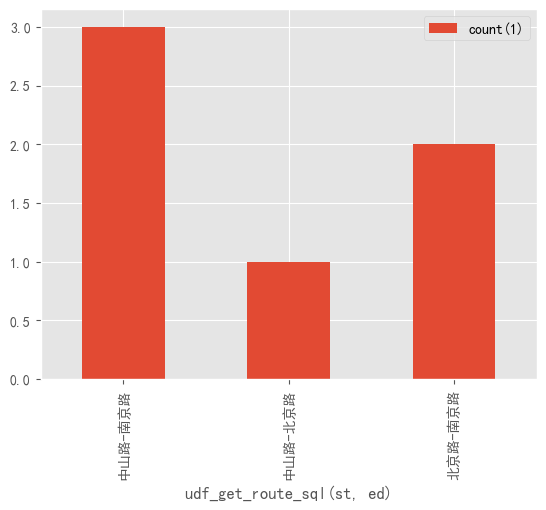

In [84]:
df.plot(kind="bar"
        ,x="udf_get_route_sql(st, ed)"
       ,y="count(1)")

In [ ]:
# spark.createDataFrame(pd_df).show() # pandas dataframe 转spark dataframe

In [86]:
spark.stop()